Step 1: Import Libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.genmod.families import Binomial
from IPython.display import display, HTML

Step 2: Load Datasets

In [21]:
#Load in csv files
housing_data = pd.read_csv('grouped_housing_data.csv')
salary_data = pd.read_csv('melted_med_hh_inc.csv')
gdp_data = pd.read_csv('msa_gdp_clean.csv')

#Load in excel files
cpi_data = pd.read_excel('Master_CPI_Annual.xlsx')
income_tax_data= pd.read_excel('state_income_tax_FULL.xlsx')


Step 3: Name all Columns with state names the same

In [22]:
#Rename the "GeoName' column to 'Region' for the gdp_data dataset
gdp_data = gdp_data.rename(columns={'GeoName': 'Region'})

#Rename the 'City' column to 'Region' for the cpi_data dataset
cpi_data = cpi_data.rename(columns={'City': 'Region'})

#Rename the 'Metropolitan area' column to 'Region' for the salary_data dataset
salary_data = salary_data.rename(columns={'Metropolitan area': 'Region'})

Step 4: Make sure all Year Columns are the same data type

In [23]:
#Convert all year columns to integer data type
housing_data['Year'] = housing_data['Year'].astype(int)
salary_data['Year'] = salary_data['Year'].astype(int)
gdp_data['Year'] = gdp_data['Year'].astype(int)
cpi_data['Year'] = cpi_data['Year'].astype(int)
income_tax_data['Year'] = income_tax_data['Year'].astype(int)

Step 5: Merge Datasets

In [24]:
#Merge all of these data sets on the 'Region' and 'Year' column keeping only what appears in every one
housing_economic_data = housing_data.merge(salary_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(gdp_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(cpi_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(income_tax_data, on=['Region','Year'], how='inner')

Step 6: Drop the 'RealGDP' column

In [25]:
#Drop column 'RealGDP' from housing_economic_data dataset
housing_economic_data = housing_economic_data.drop(columns=['RealGDP'])

Step 7: Create a new column named 'After Tax Income'

In [26]:
# Create the 'After Tax Income' column by multiplying the 'Median Household Income' column by (1 - 'Income Tax Rate')
housing_economic_data['After_Tax_Income'] = housing_economic_data['Median_Household_Income'] * (1 - housing_economic_data['Tax Rate'])

Step 8: Change column names to have underscores instead of spaces

In [27]:
#Change all column names to have underscores instead of spaces
housing_economic_data.columns = housing_economic_data.columns.str.replace(' ', '_')

Step 9: Do a regression analysis for Home Price Prediction

In [28]:
#Do a regression analysis to predict the 'Median Home Price' using the other columns as features
housing_price_1 = smf.ols('Median_Sale_Price ~ Median_Household_Income', data = housing_economic_data).fit()
housing_price_2 = smf.ols('Median_Sale_Price ~ CurrentGDP', data = housing_economic_data).fit()
housing_price_3 = smf.ols('Median_Sale_Price ~ Annual_CPI', data = housing_economic_data).fit()
housing_price_4 = smf.ols('Median_Sale_Price ~ After_Tax_Income', data = housing_economic_data).fit()
housing_price_comb = smf.ols('Median_Sale_Price ~ Median_Household_Income + CurrentGDP + Annual_CPI + After_Tax_Income', data = housing_economic_data).fit()

results_table = summary_col([housing_price_1, housing_price_2, housing_price_3, housing_price_4, housing_price_comb],
                          stars = True,
                          model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Combined Model'],
                          info_dict = {'N' : lambda x: f"{int(x.nobs)}"})

print(results_table)


                            Model 1        Model 2         Model 3         Model 4      Combined Model
------------------------------------------------------------------------------------------------------
Intercept               -326704.0494*** 297428.2279*** -248748.6441*** -238467.7445*** -508849.6178***
                        (78954.4633)    (29610.1400)   (84026.1061)    (82496.6016)    (76905.7254)   
Median_Household_Income 10.2063***                                                     55.2408***     
                        (1.0564)                                                       (5.8931)       
CurrentGDP                              0.0003***                                      0.0001         
                                        (0.0001)                                       (0.0000)       
Annual_CPI                                             2744.6894***                    1697.6627***   
                                                       (337.9463)       

Step 10: Make graph with the average of all housing prices throughout the years

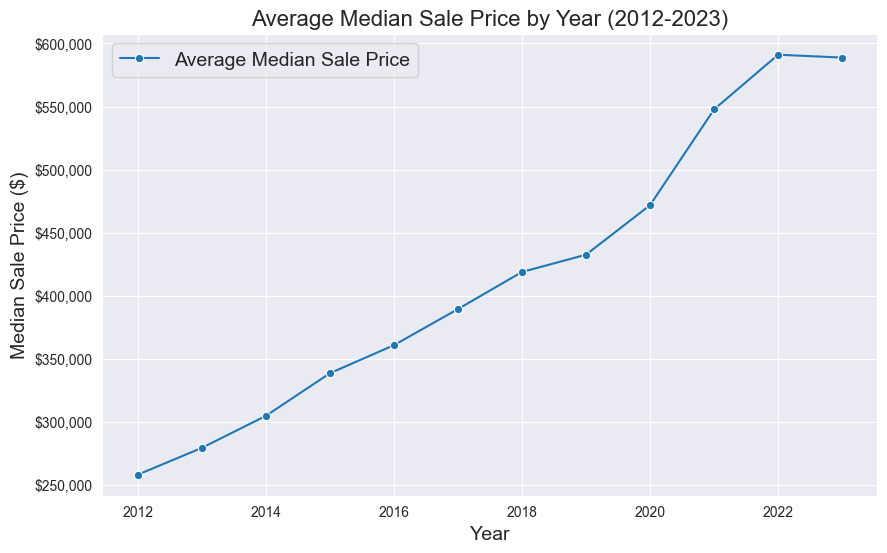

In [29]:
#Make a line chart that has the 'Year' on the x-axis and the average 'Median_Sale_Price' on the y-axis
housing_price_avg = housing_economic_data.groupby('Year')['Median_Sale_Price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=housing_price_avg, x='Year', y='Median_Sale_Price', label='Average Median Sale Price', marker='o')
plt.title('Average Median Sale Price by Year (2012-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Median Sale Price ($)', fontsize=14)
plt.legend(fontsize=14)
#Change the y-ticks to be formatted as currency
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.show()


Step 11: Create Individual Graphs for Visualization

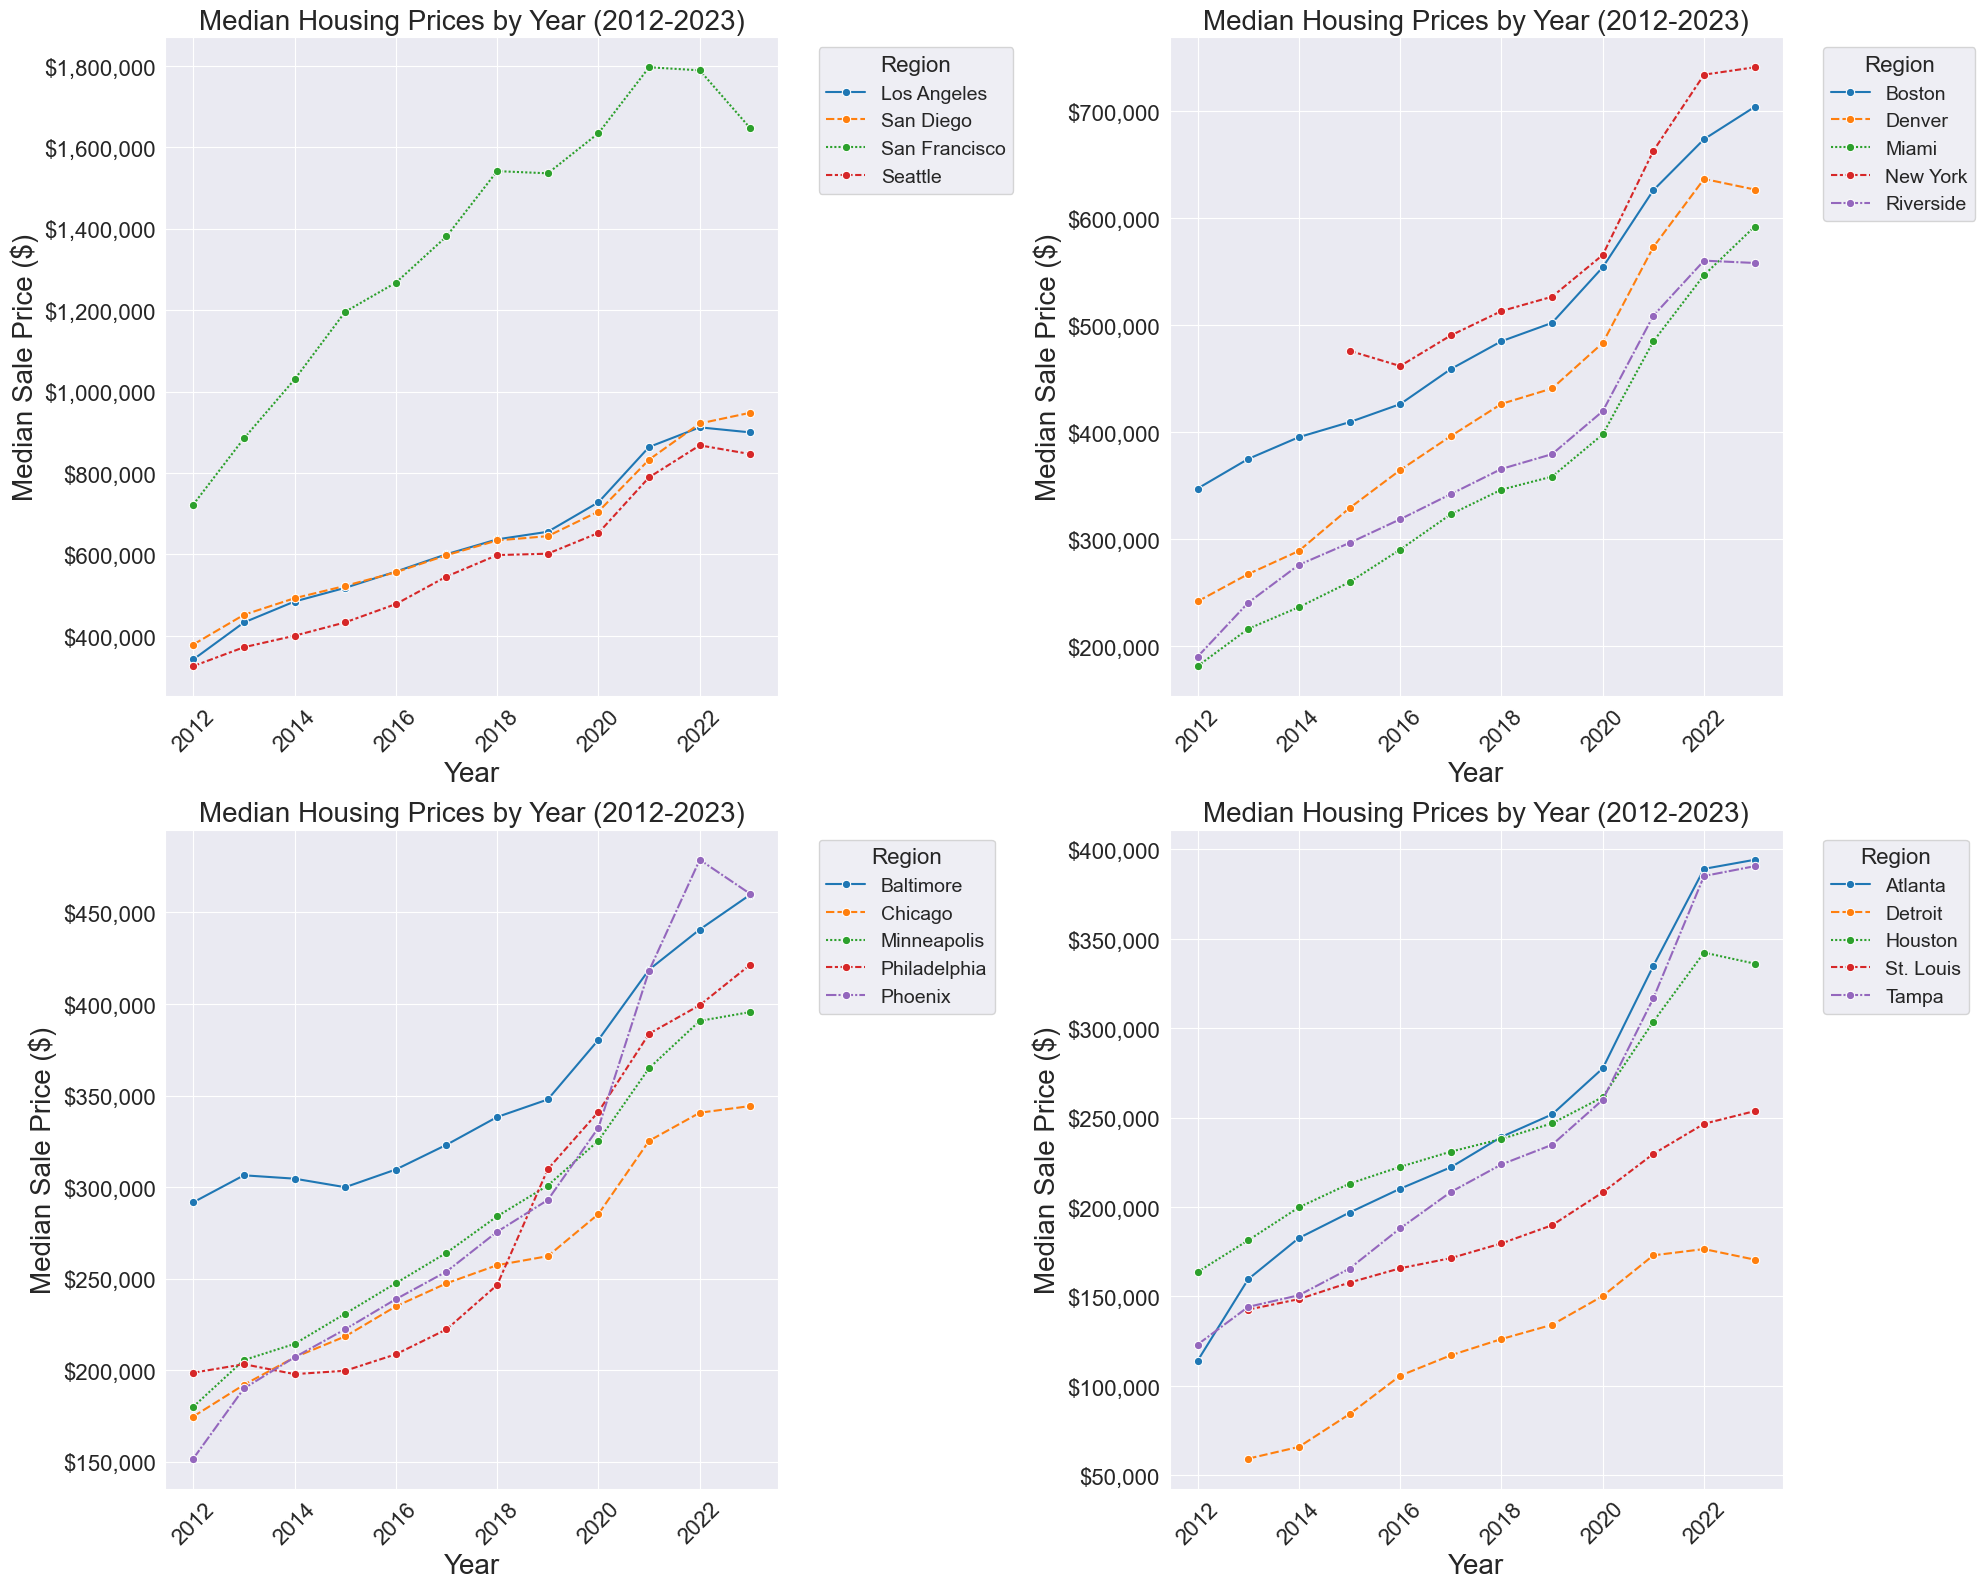

In [30]:
#Create 4 line plots that show the 'Year' on the x-axis and 'Median_Sale_Price' on the y-axis for every 'Region' as a hue. Make four quadrants based on the 'Region'. The quadrants should include the following cities. Quadrant 1: San Francisco, San Diego, Los Angeles, Seattle. Quadrant 2: New York City, Boston, Denver, Riverside, Miami. Quadrant 3: Baltimore, Phoenix, Minneapolis, Philadelphia, Chicago. Quadrant 4: Atlanta, Houston, Tampa, St. Louis, Detroit
regions_quadrants = {
    'Quadrant 1': ['San Francisco', 'San Diego', 'Los Angeles', 'Seattle'],
    'Quadrant 2': ['New York', 'Boston', 'Denver', 'Riverside', 'Miami'],
    'Quadrant 3': ['Baltimore', 'Phoenix', 'Minneapolis', 'Philadelphia', 'Chicago'],
    'Quadrant 4': ['Atlanta', 'Houston', 'Tampa', 'St. Louis', 'Detroit']
}

#Put these four line plots together in one visual. Change each line type
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
for ax, (quadrant, regions) in zip(axs.flatten(), regions_quadrants.items()):
    sns.lineplot(data=housing_economic_data[housing_economic_data['Region'].isin(regions)],
                 x='Year', y='Median_Sale_Price', hue='Region', marker='o', style='Region', ax=ax)
    ax.set_title(f'Median Housing Prices by Year (2012-2023)', fontsize=20)
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Median Sale Price ($)', fontsize=20)
    ax.legend(title='Region', title_fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

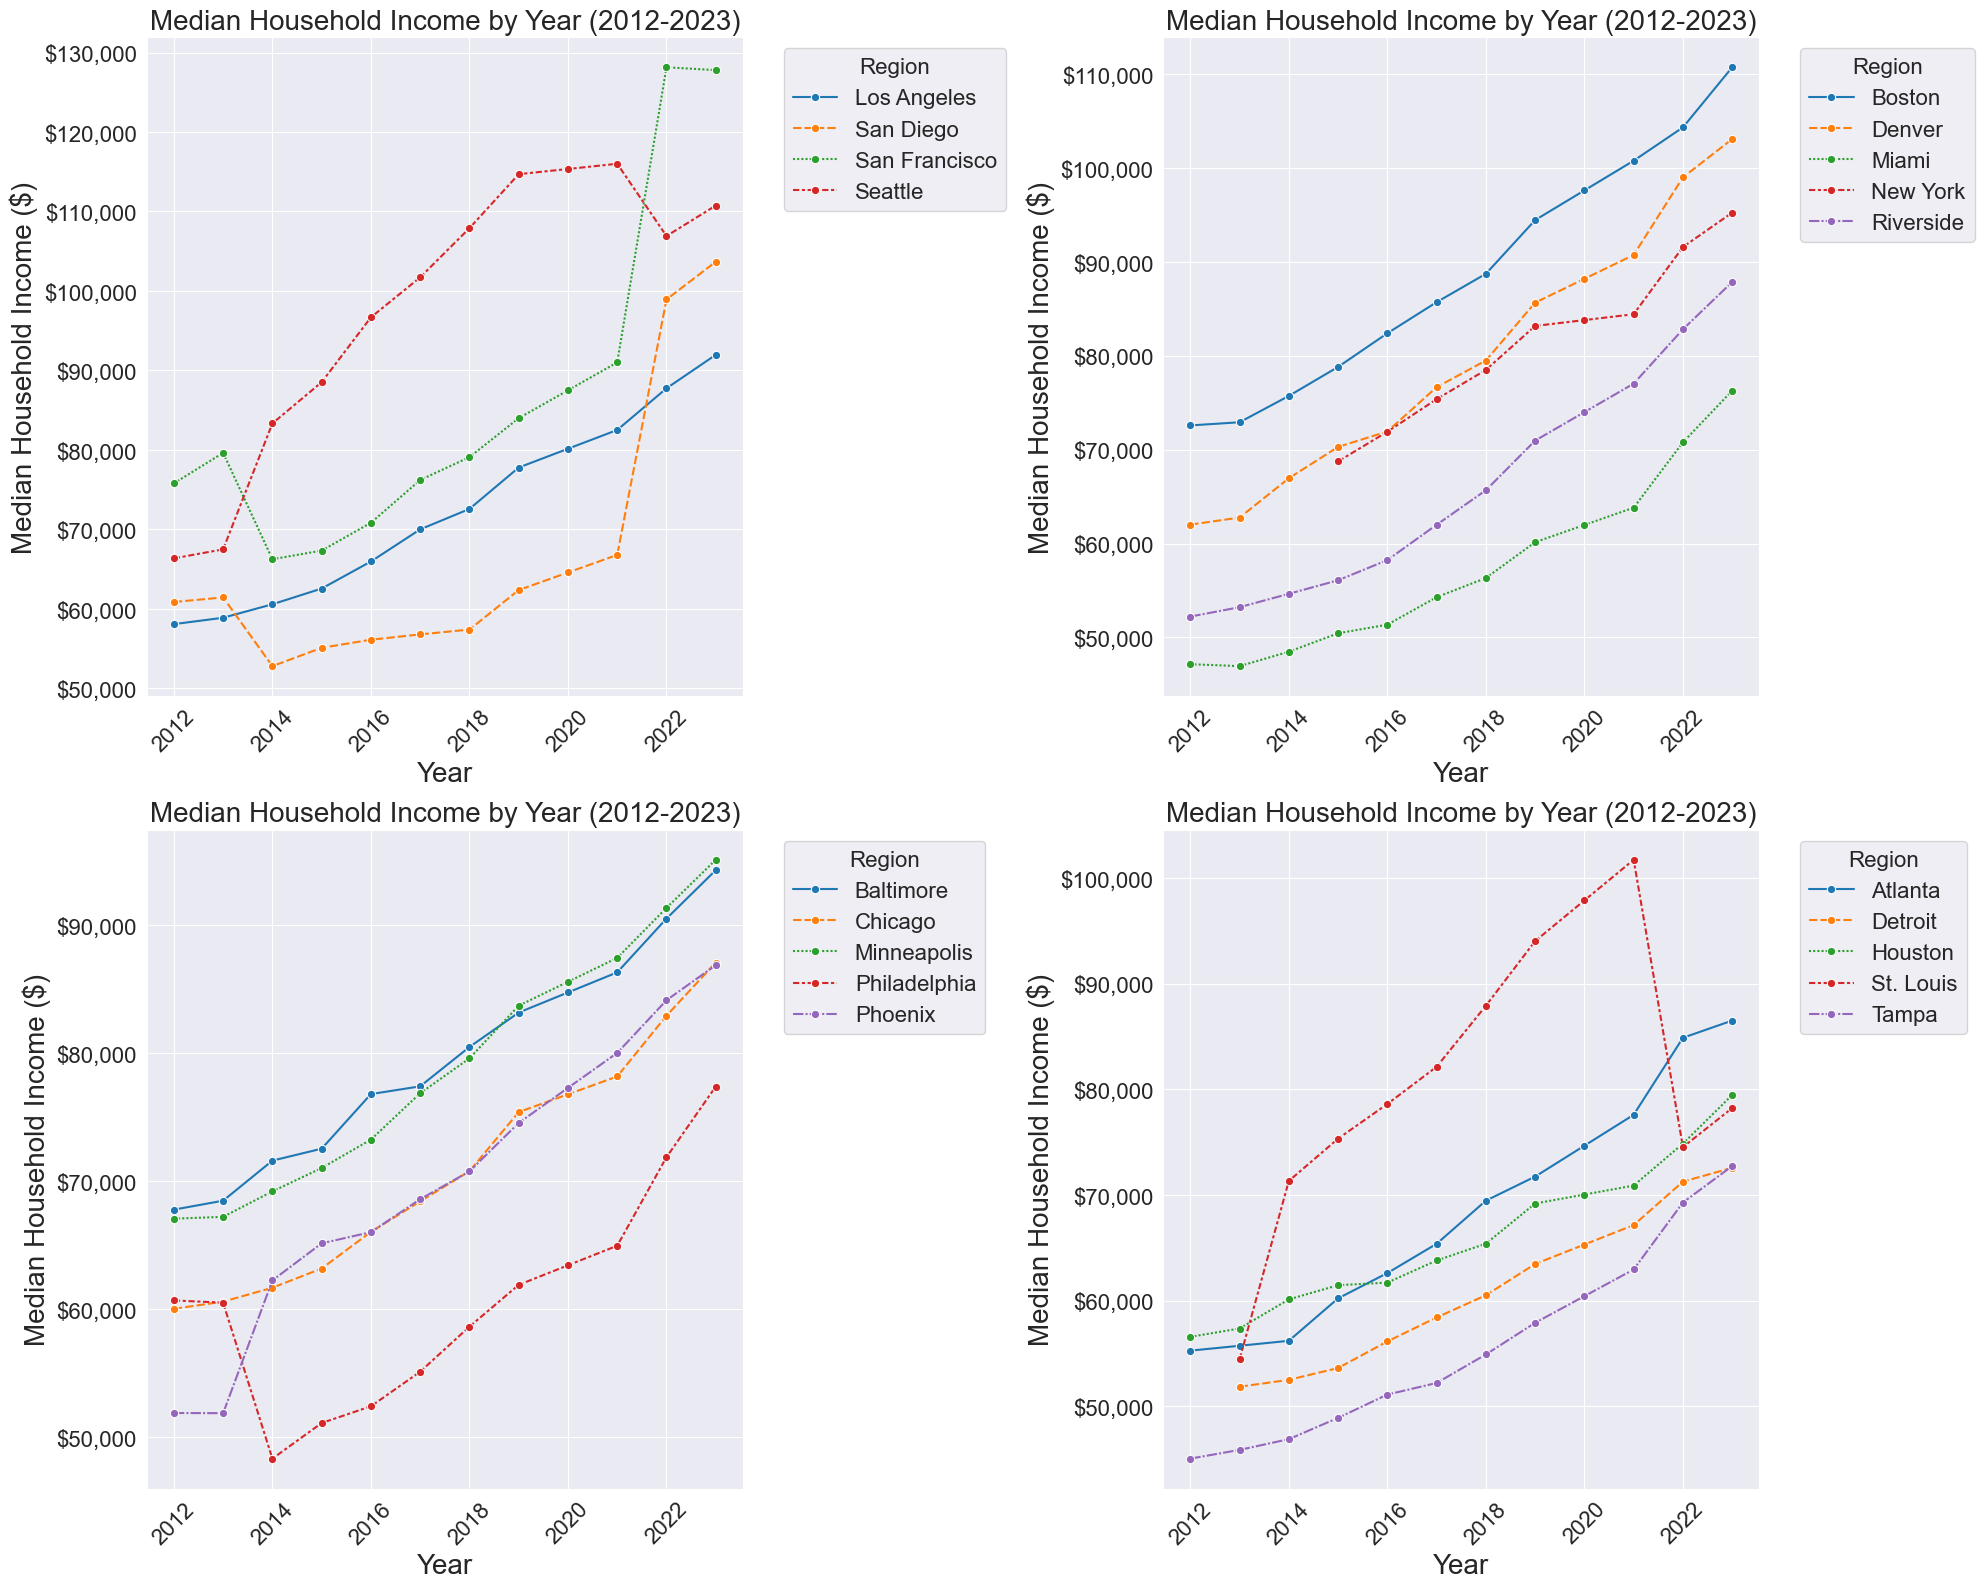

In [31]:
#Create a line plot with 'Median_Household_Income on the y-axis using the same groups as above
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
for ax, (quadrant, regions) in zip(axs.flatten(), regions_quadrants.items()):
    sns.lineplot(data=housing_economic_data[housing_economic_data['Region'].isin(regions)],
                 x='Year', y='Median_Household_Income', hue='Region', marker='o', style='Region', ax=ax)
    ax.set_title(f'Median Household Income by Year (2012-2023)', fontsize=20)
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Median Household Income ($)', fontsize=20)
    ax.legend(title='Region', title_fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

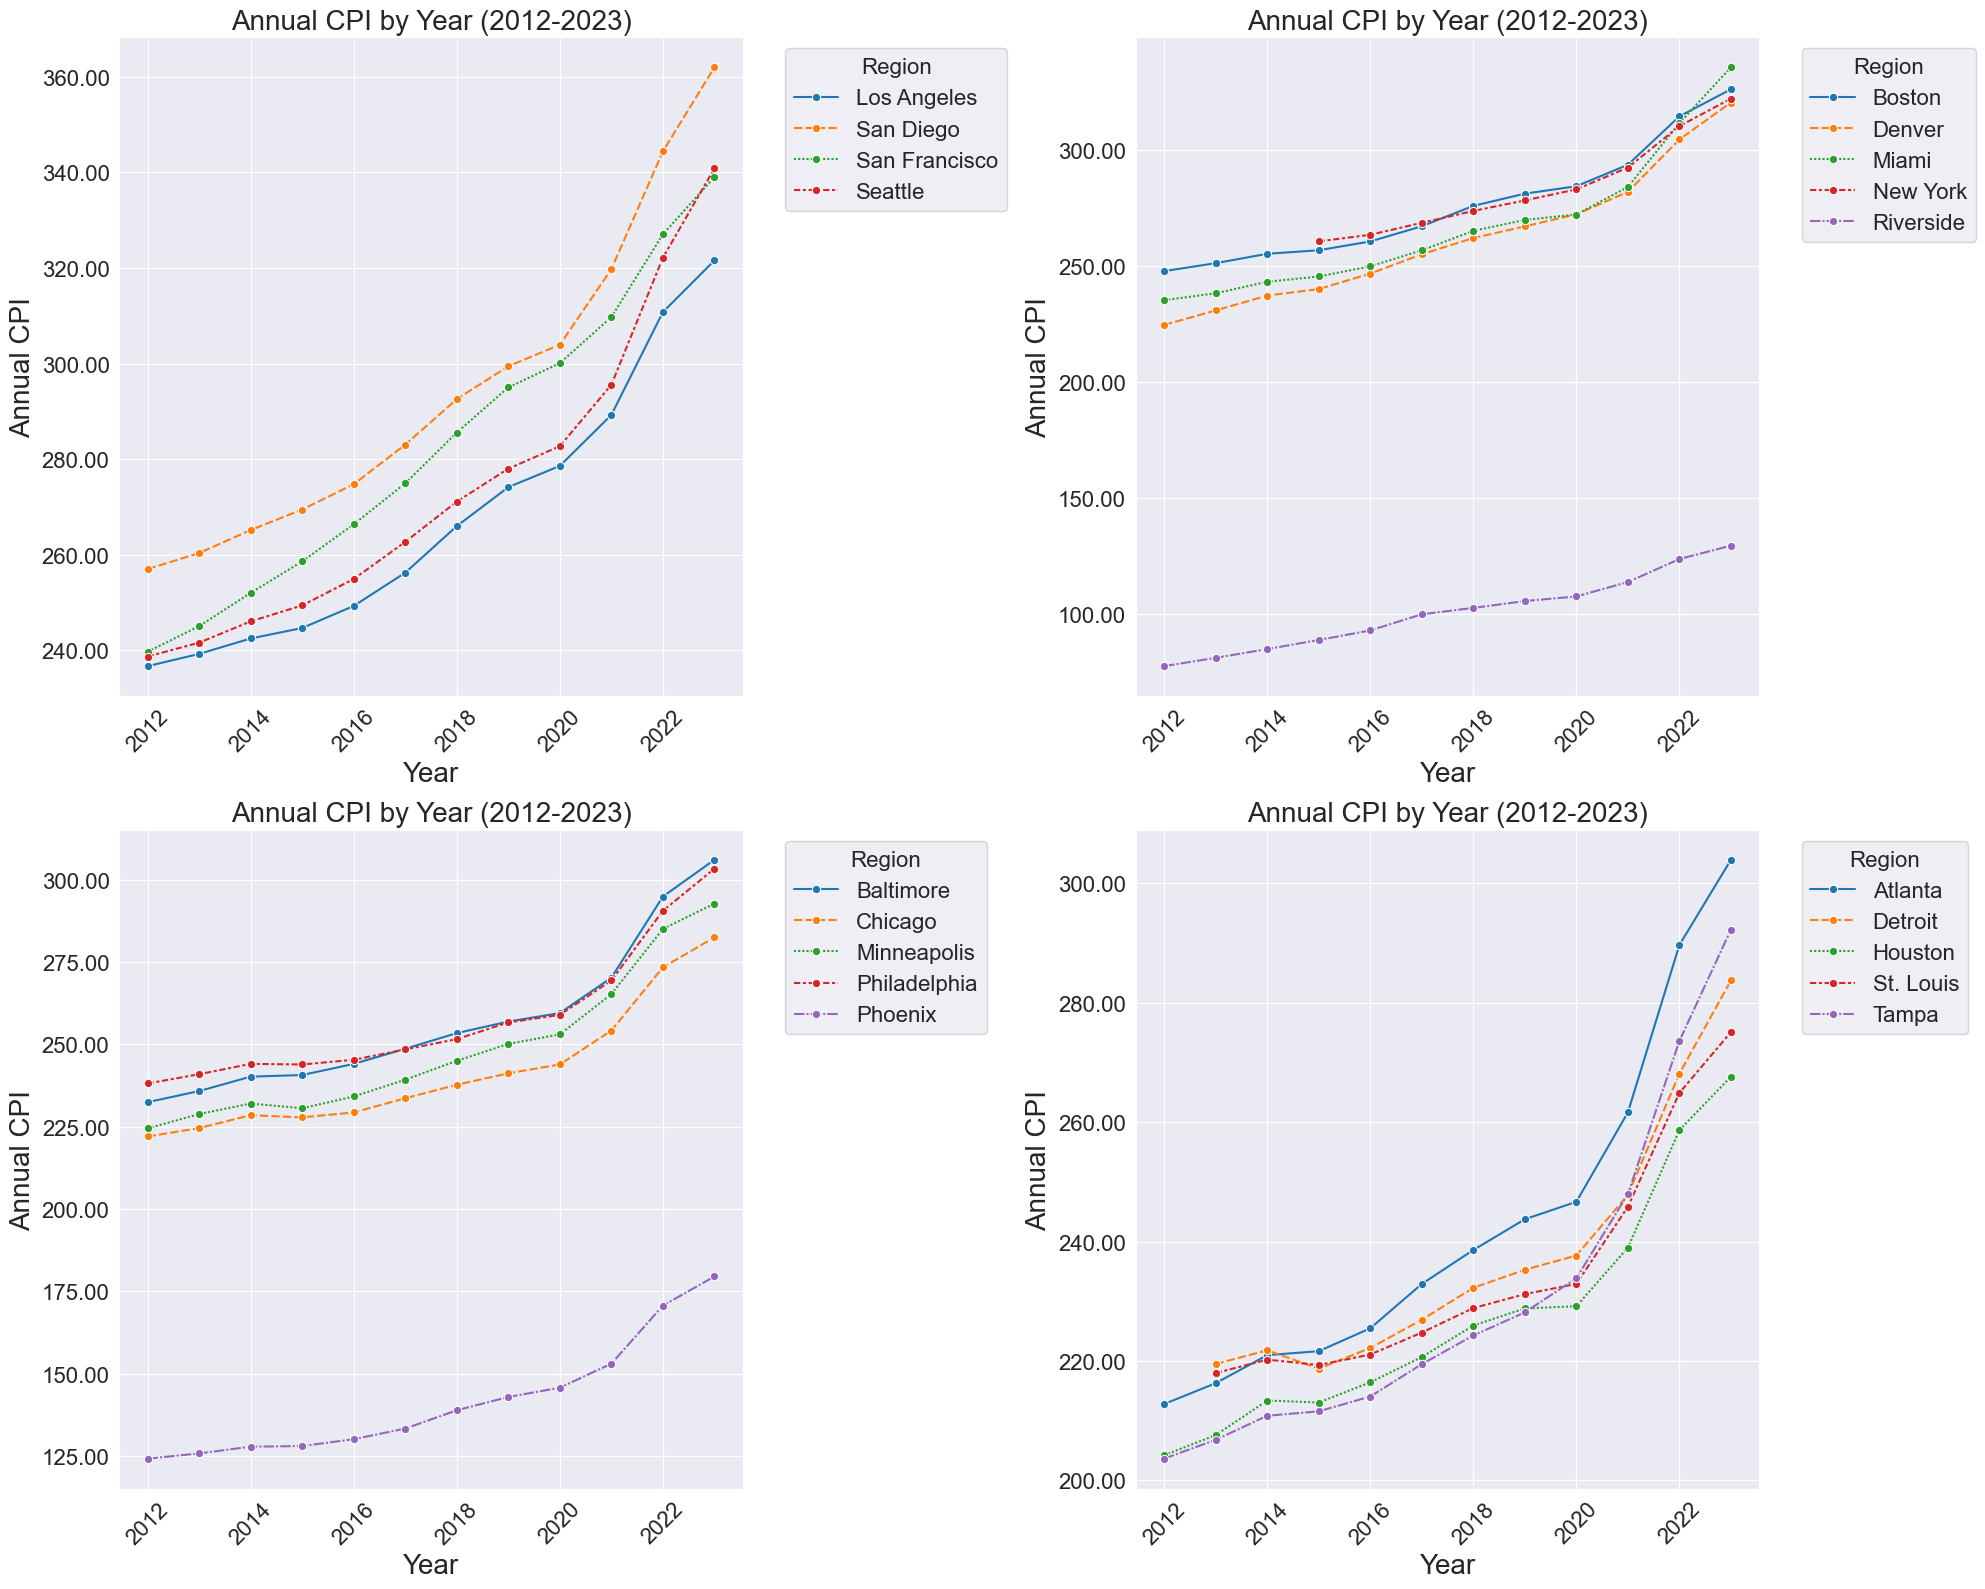

In [32]:
#Create a line plot with 'Annual_CPI' on the y-axis using the same groups as above
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
for ax, (quadrant, regions) in zip(axs.flatten(), regions_quadrants.items()):
    sns.lineplot(data=housing_economic_data[housing_economic_data['Region'].isin(regions)],
                 x='Year', y='Annual_CPI', hue='Region', marker='o', style='Region', ax=ax)
    ax.set_title(f'Annual CPI by Year (2012-2023)', fontsize=20)
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Annual CPI', fontsize=20)
    ax.legend(title='Region', title_fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.2f}'))
plt.tight_layout()
plt.show()

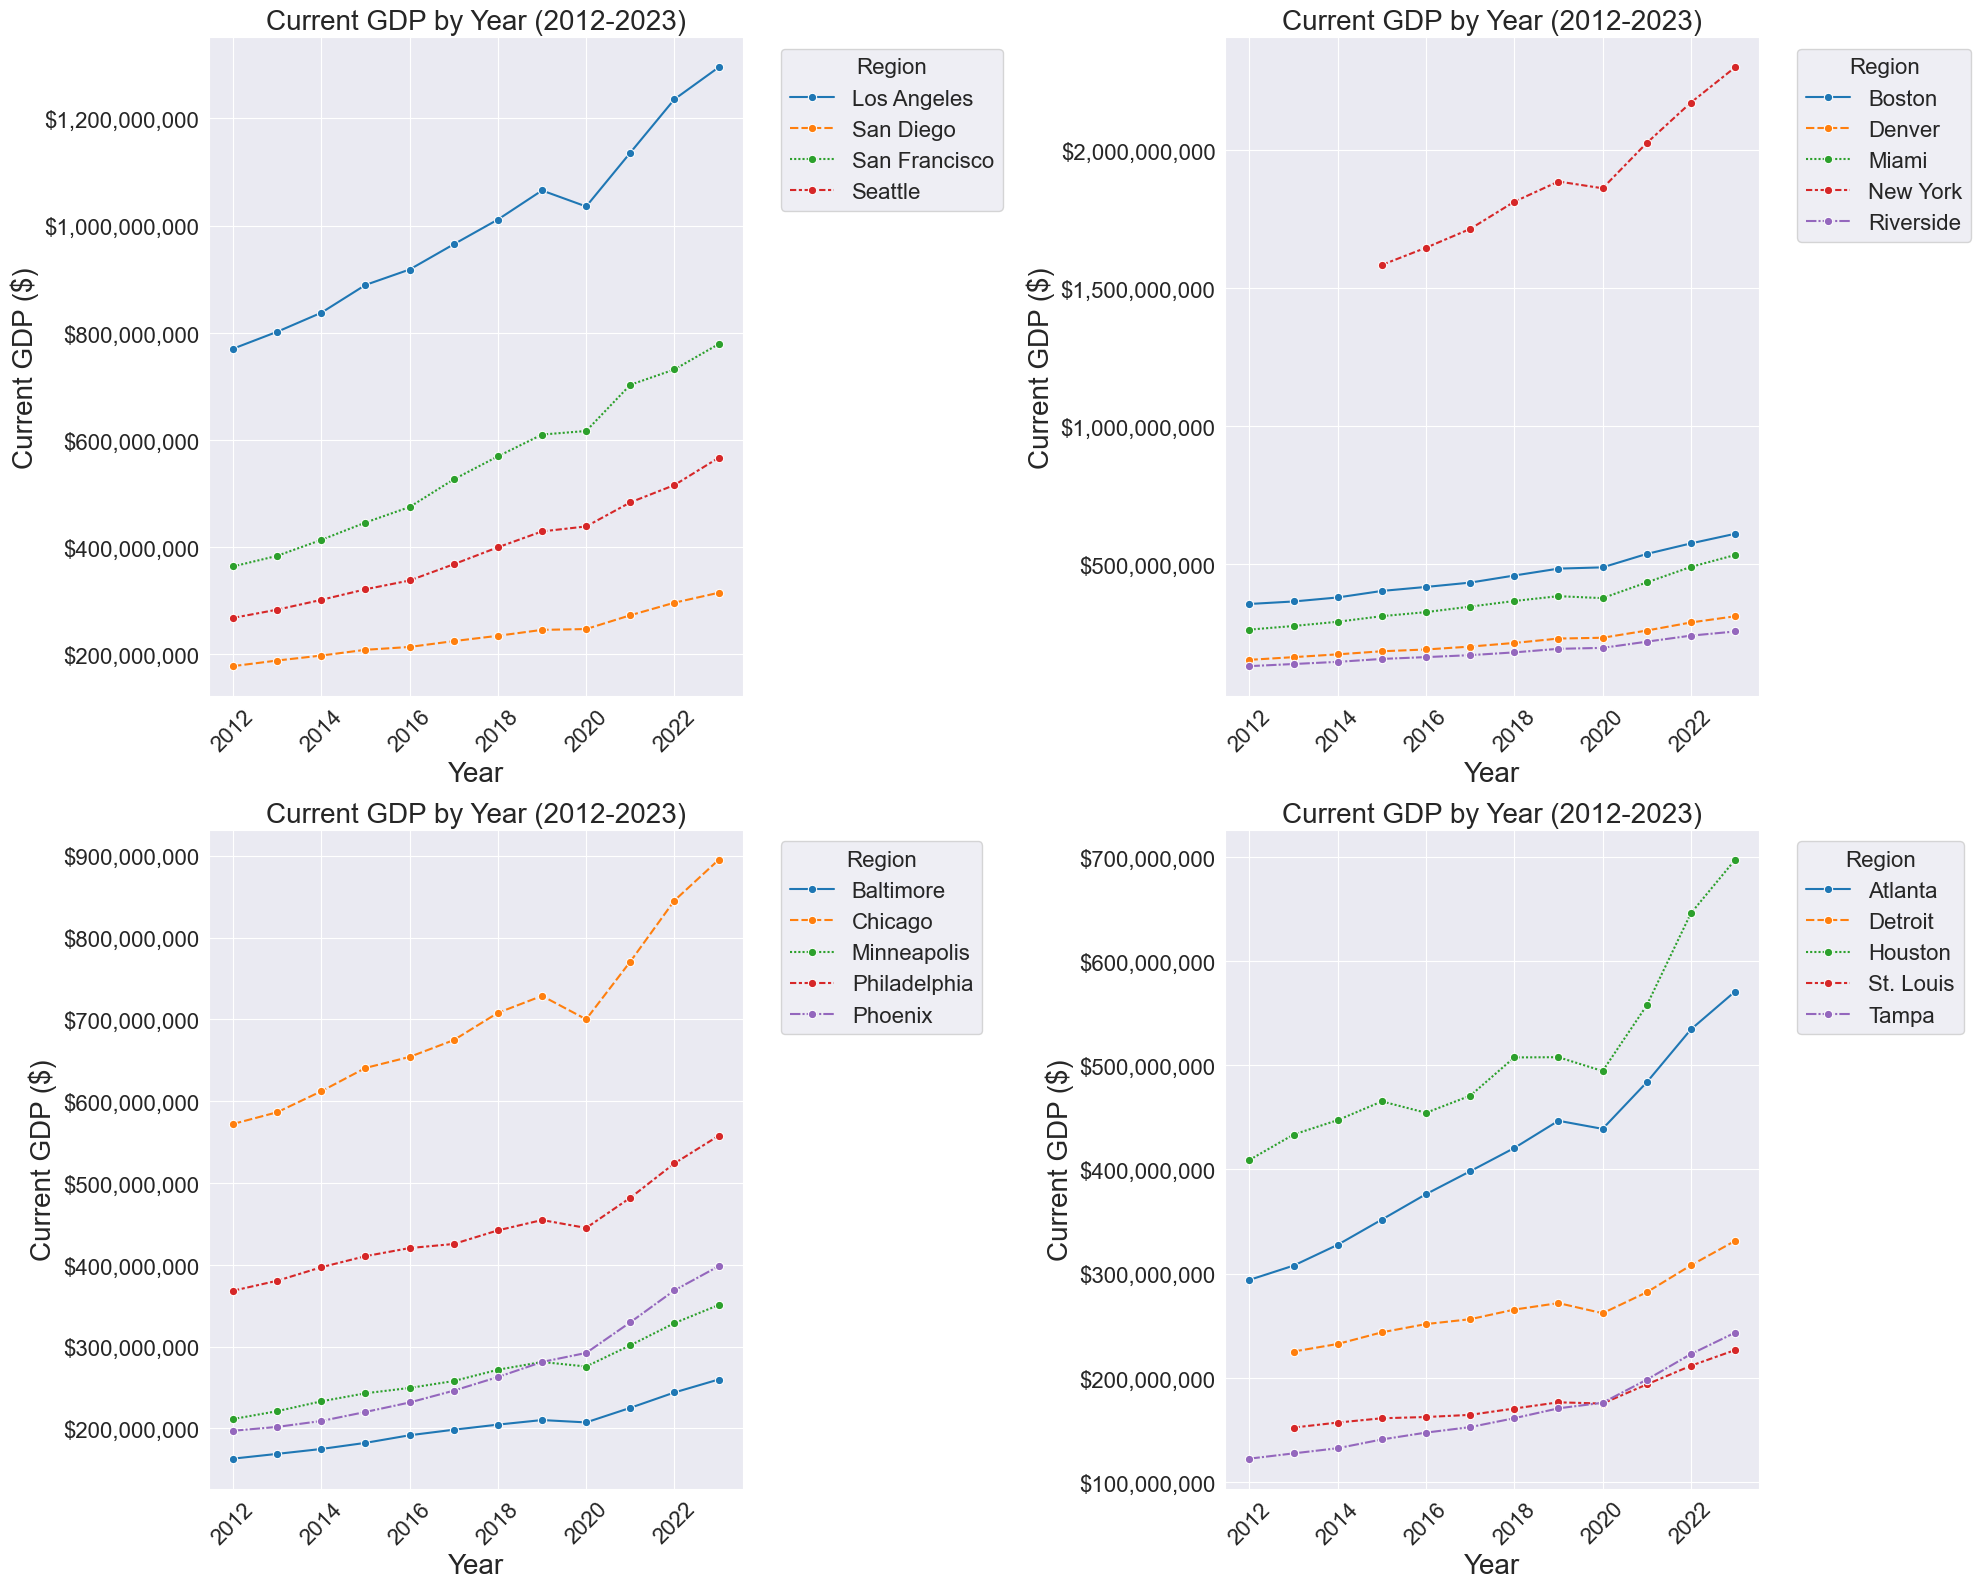

In [33]:
#Create a line plot with 'CurrentGDP' on the y-axis using the same groups as above
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
for ax, (quadrant, regions) in zip(axs.flatten(), regions_quadrants.items()):
    sns.lineplot(data=housing_economic_data[housing_economic_data['Region'].isin(regions)],
                 x='Year', y='CurrentGDP', hue='Region', marker='o', style='Region', ax=ax)
    ax.set_title(f'Current GDP by Year (2012-2023)', fontsize=20)
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Current GDP ($)', fontsize=20)
    ax.legend(title='Region', title_fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

Step 12: Find Predicted Prices and label as 'Undervalued' or 'Overvalued'

In [34]:
#Find the predicted prices for these median sale prices using the combined model
housing_economic_data['Predicted_Median_Sale_Price'] = housing_price_comb.predict(housing_economic_data)

#Creat a new variable named 'Price_Difference' that is the difference between the 'Median_Sale_Price' and the 'Predicted_Median_Sale_Price'
housing_economic_data['Price_Difference'] = housing_economic_data['Median_Sale_Price'] - housing_economic_data['Predicted_Median_Sale_Price']

#Create a column that is either 'Overvalued' or Undervalued' based on if the 'Price_Difference' is greater than 0 or less than 0
housing_economic_data['Price_Classification'] = np.where(housing_economic_data['Price_Difference'] > 0, 'Overvalued', 'Undervalued')

Step 13: Create line plots for each region plotting actual vs predicted prices

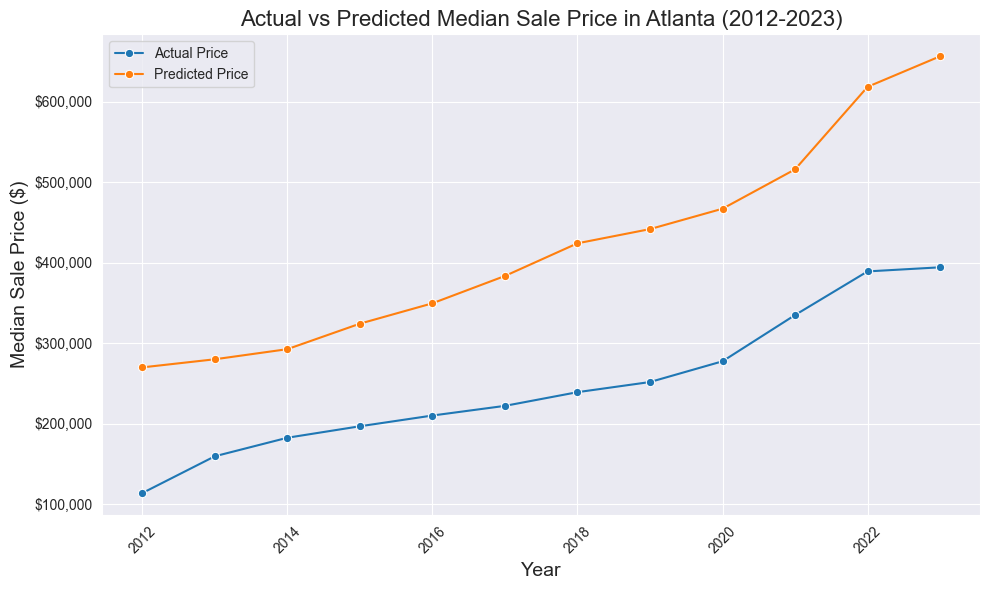

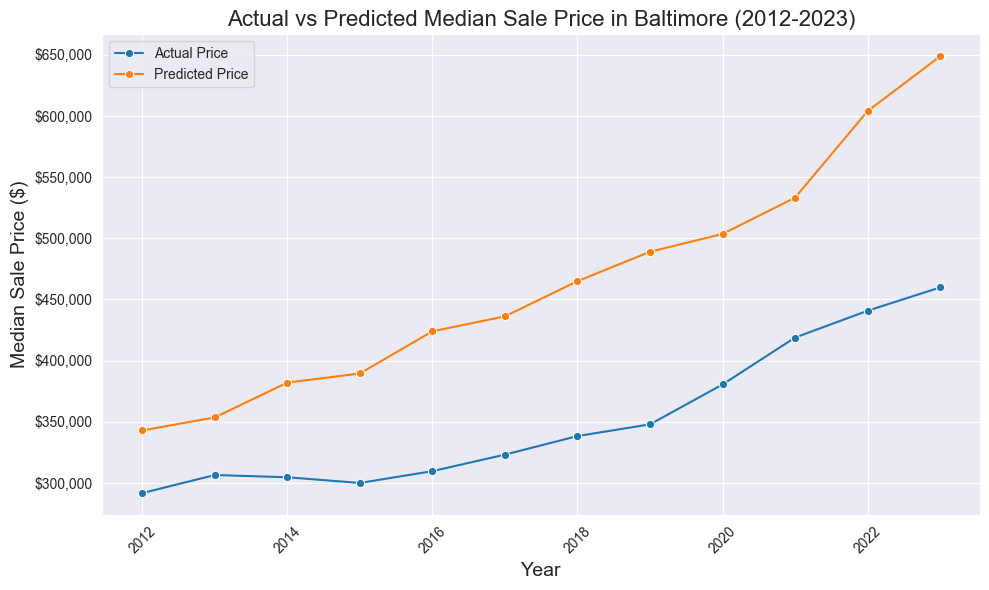

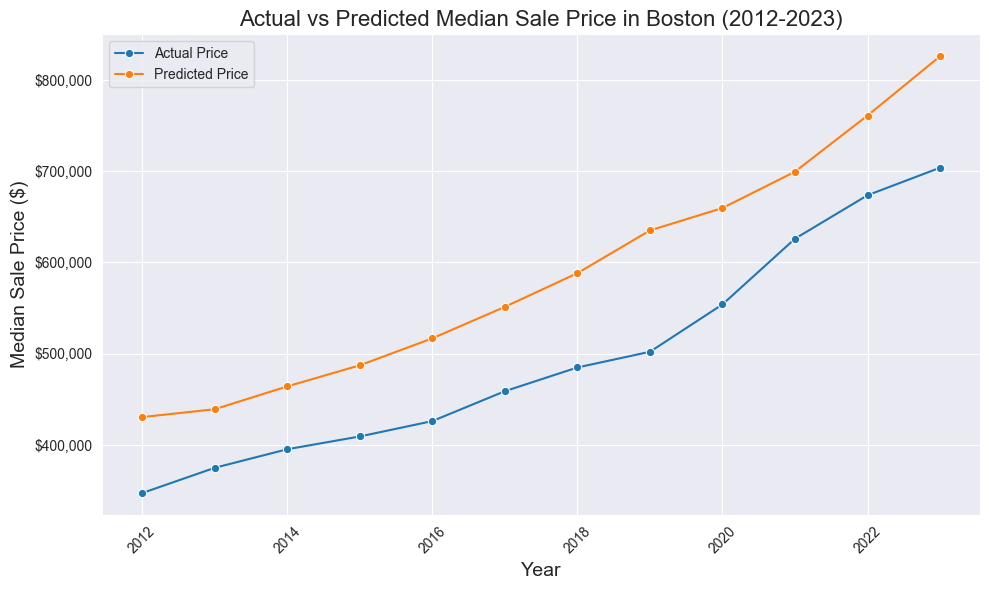

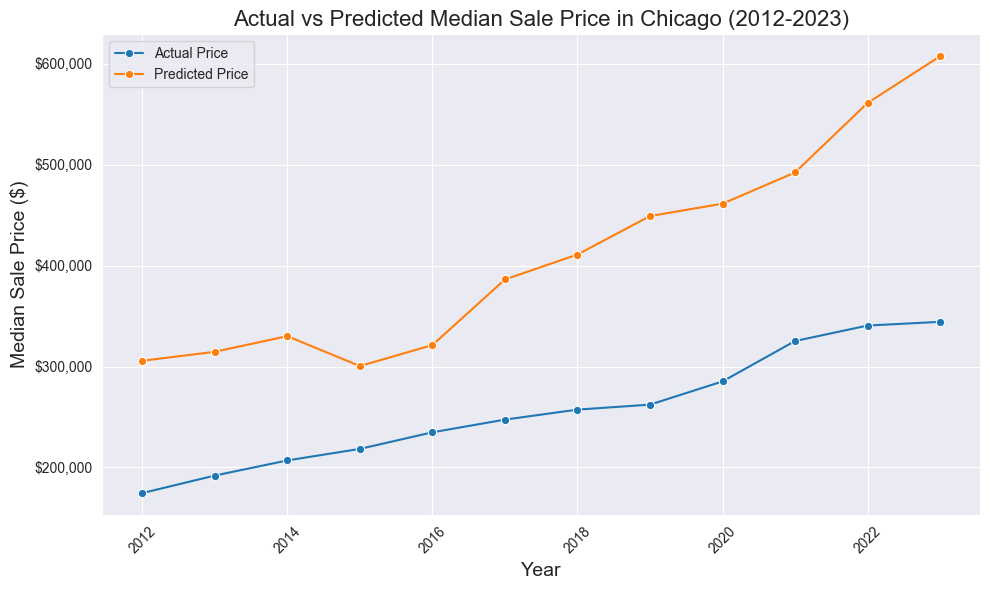

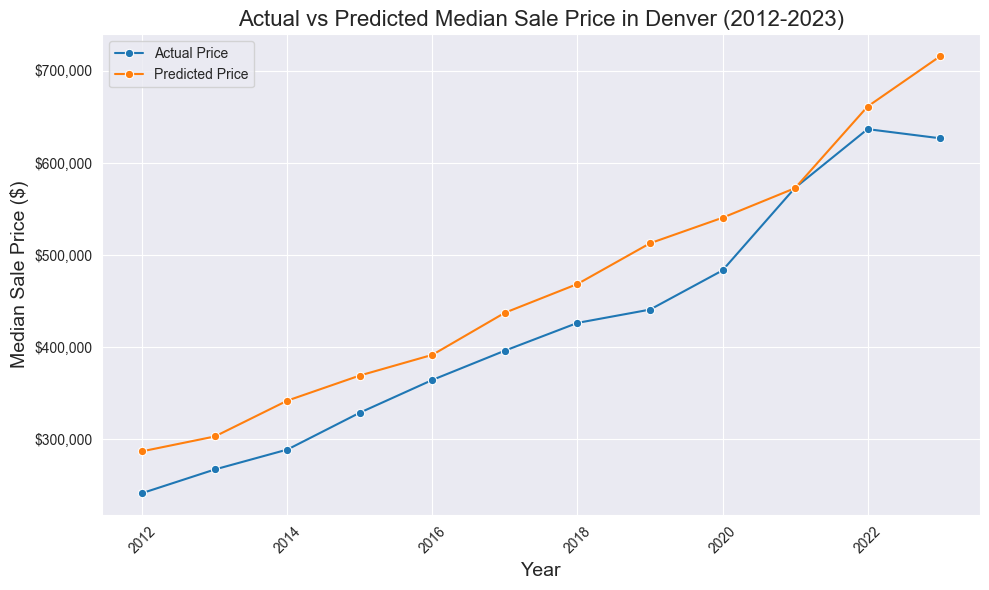

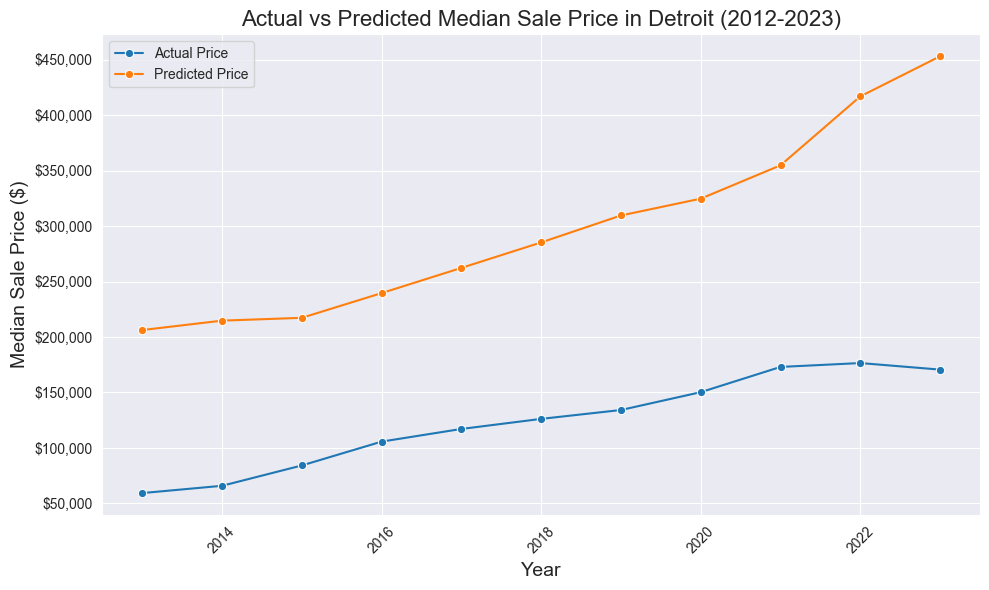

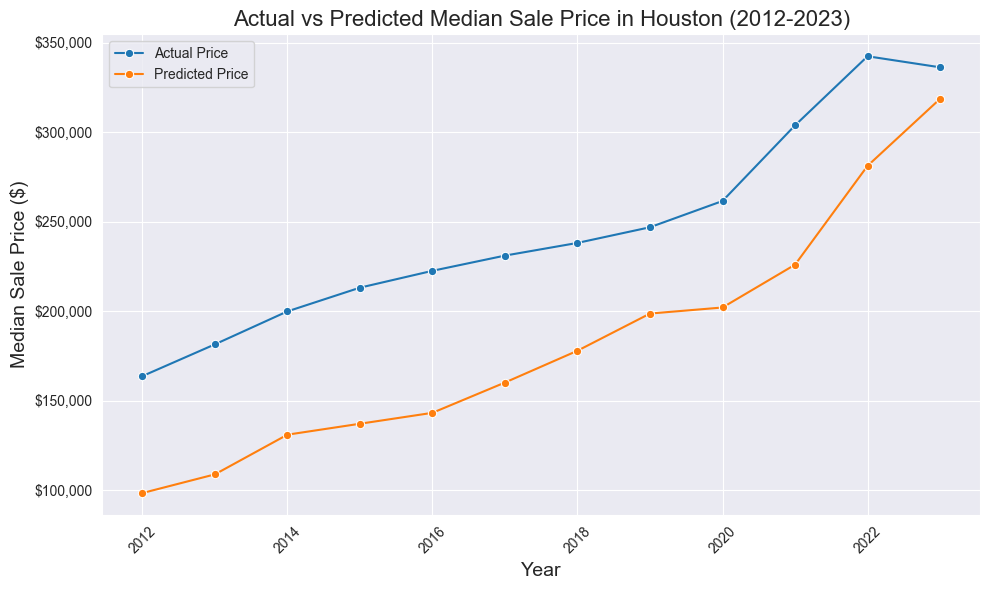

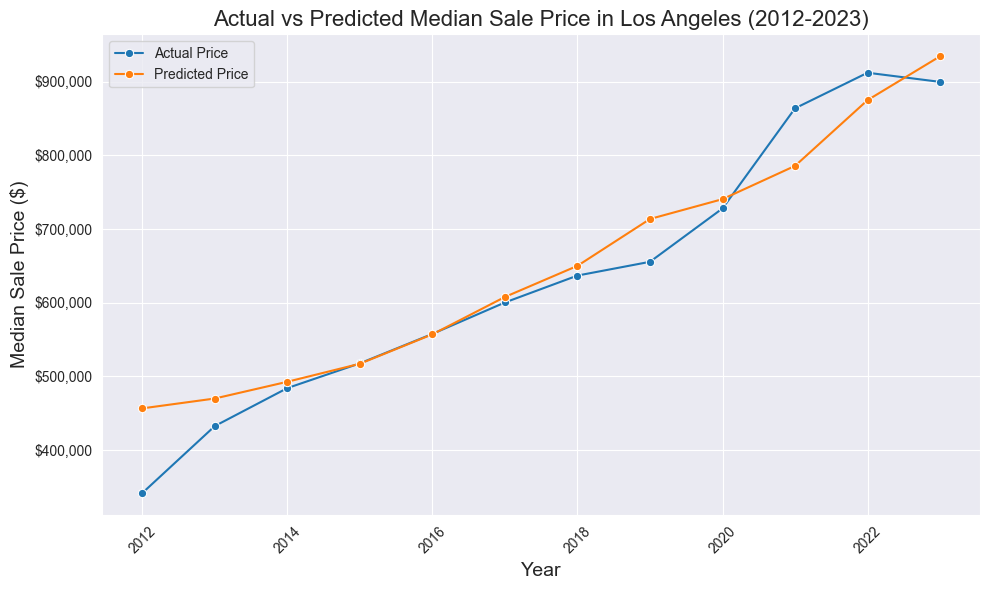

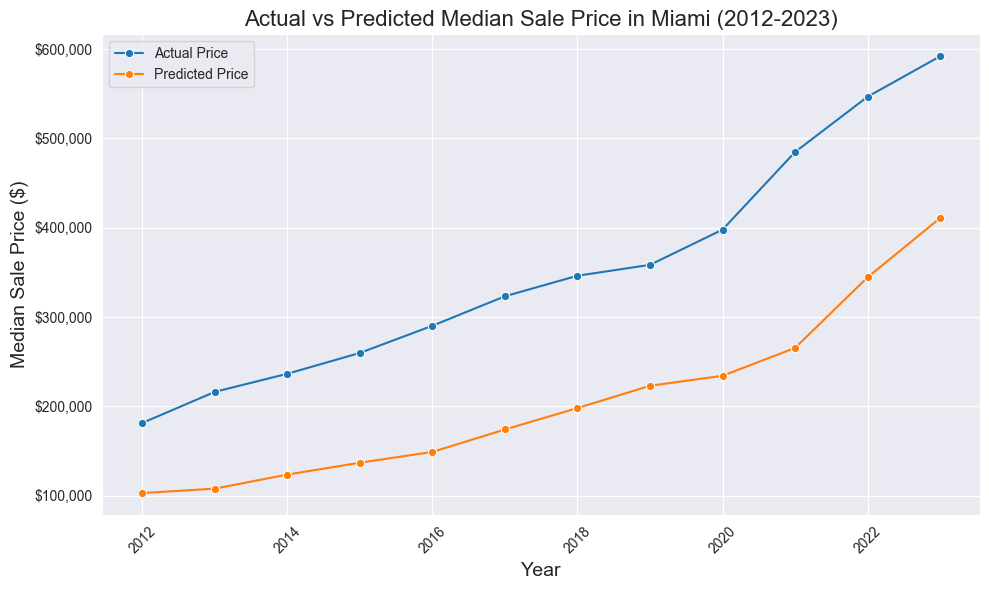

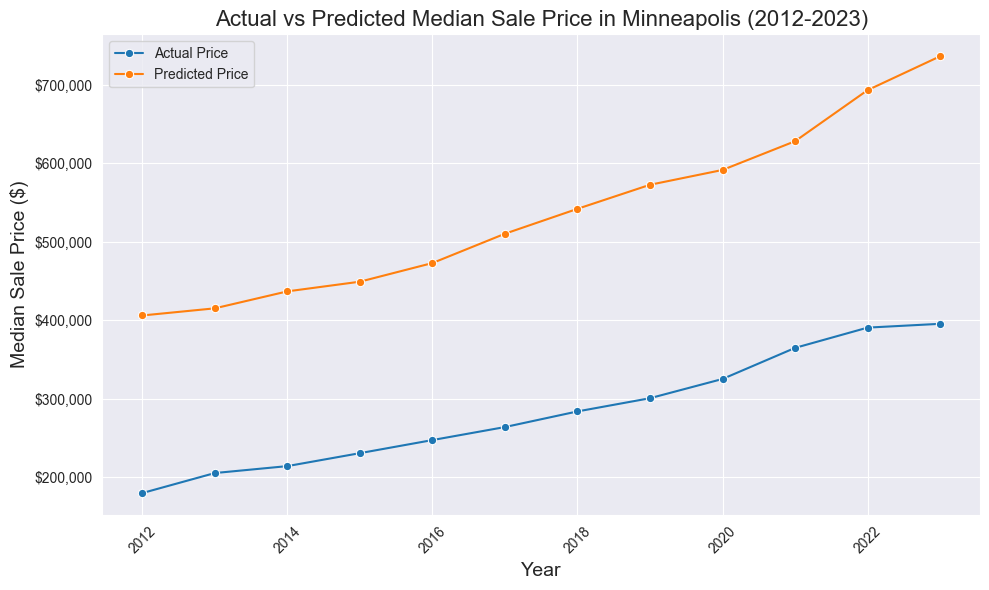

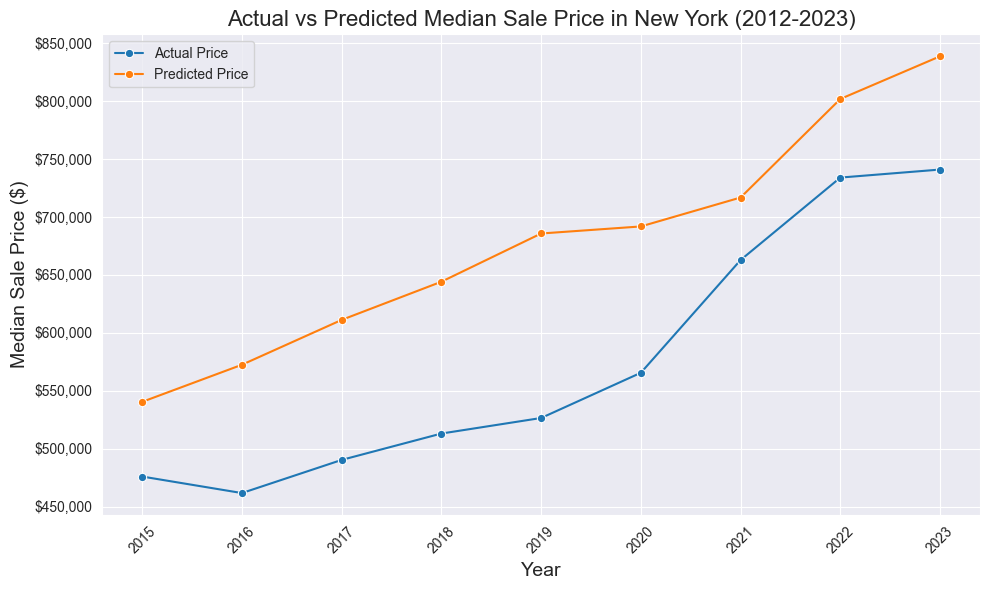

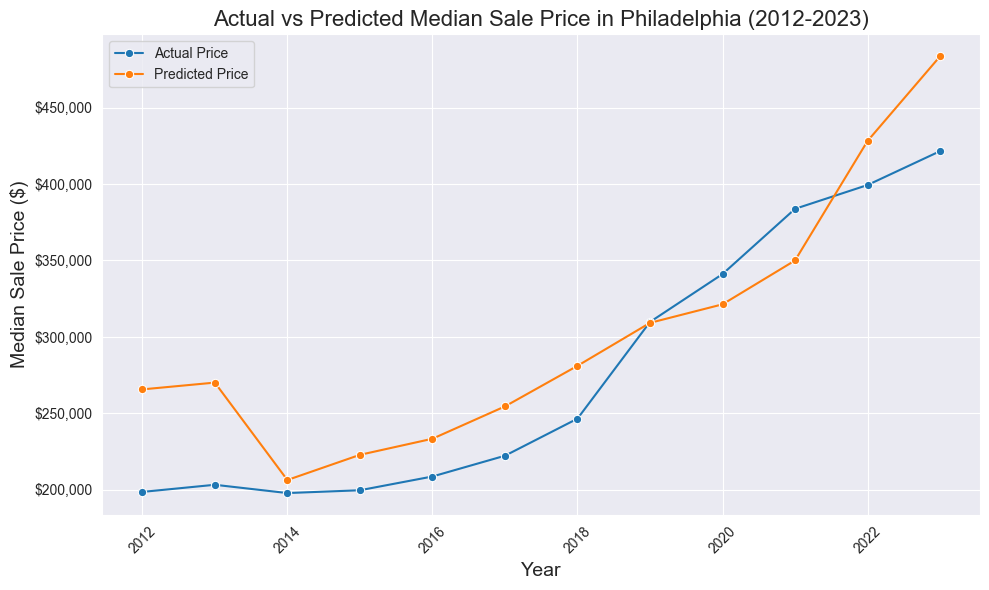

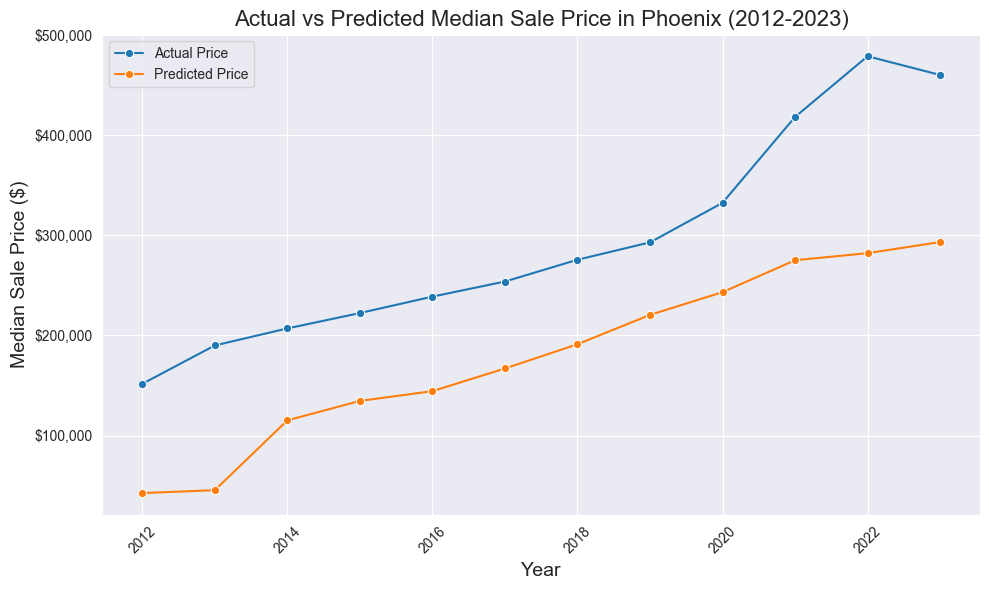

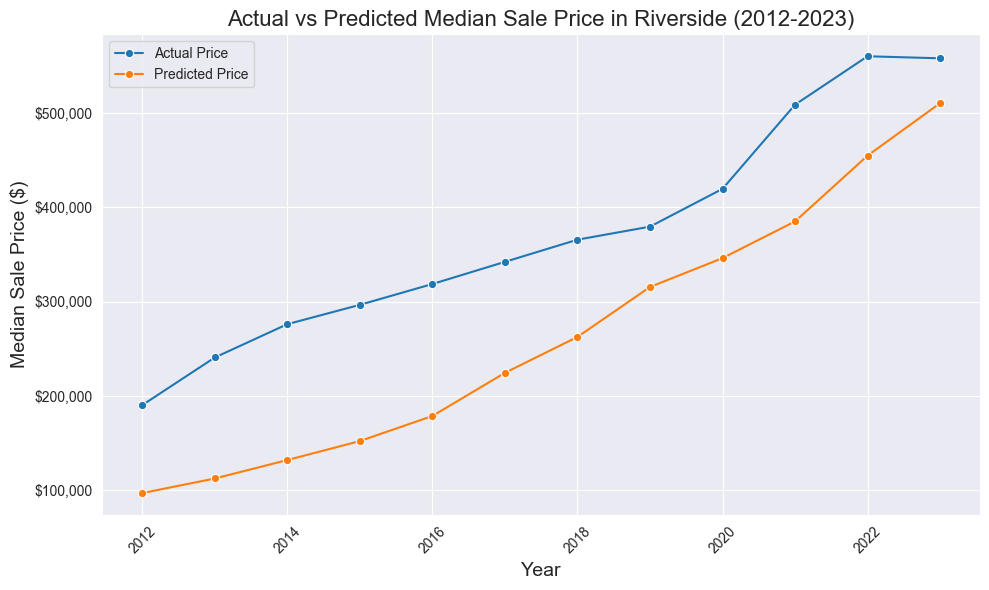

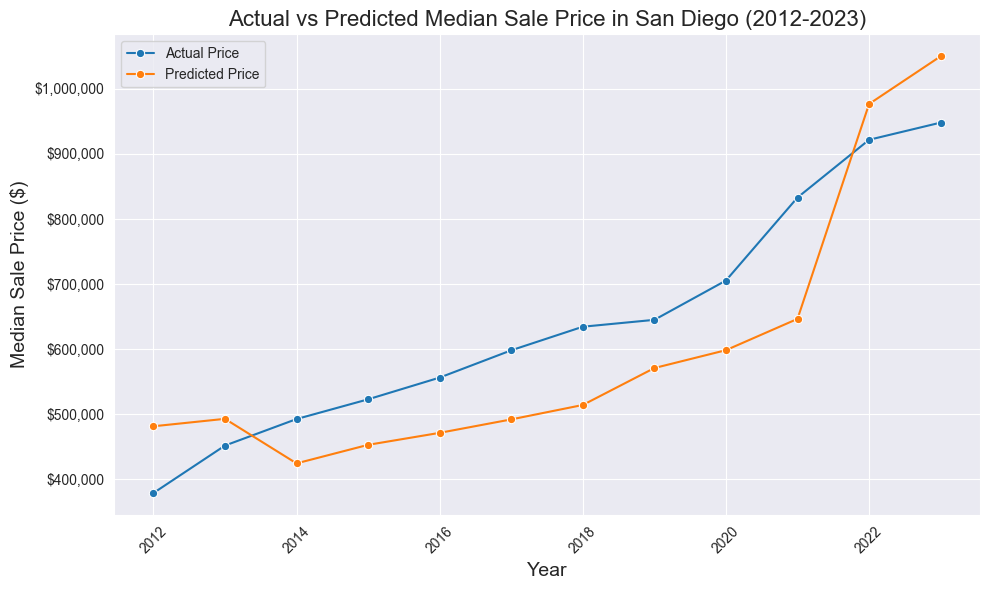

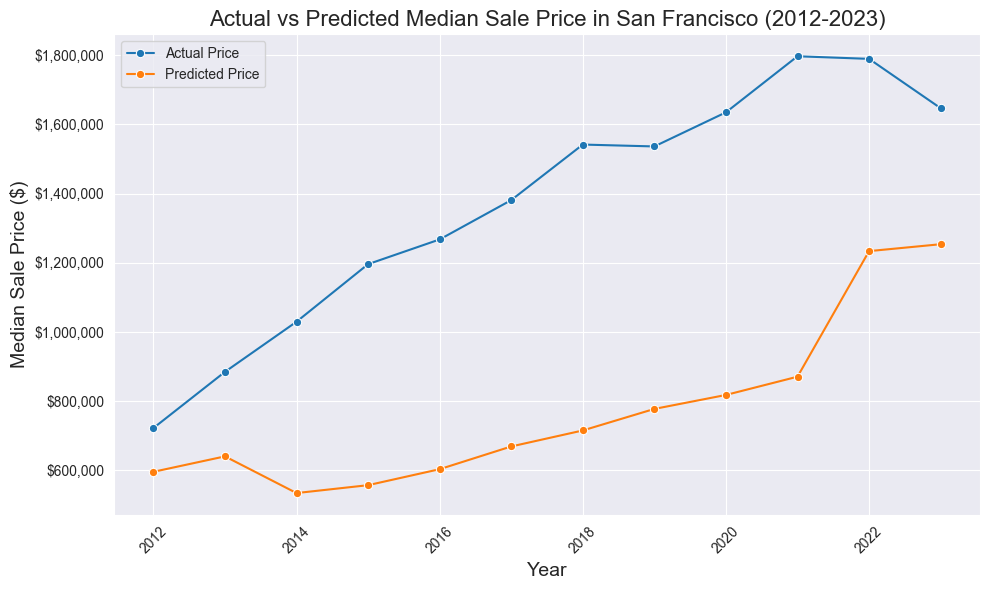

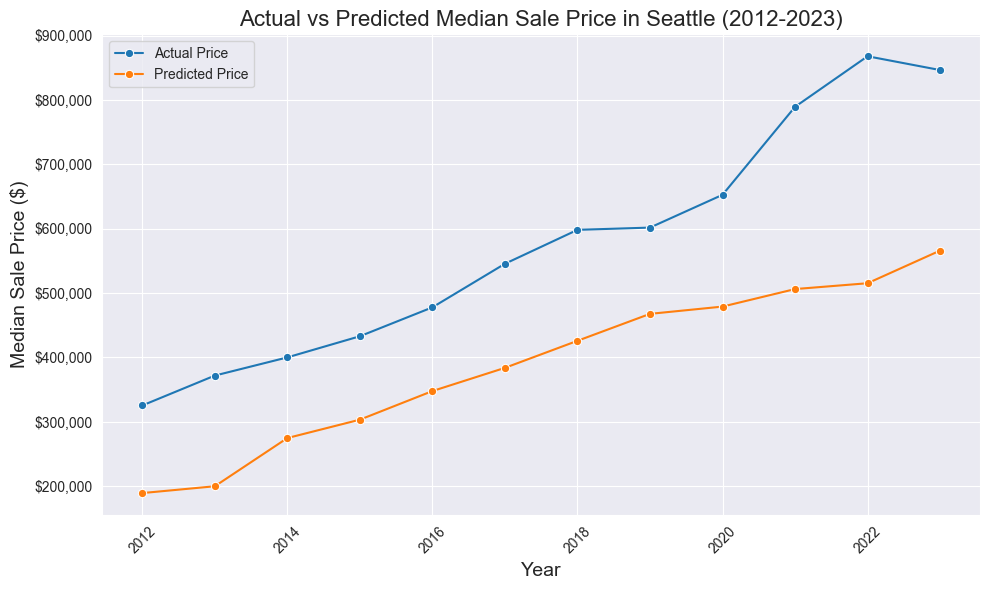

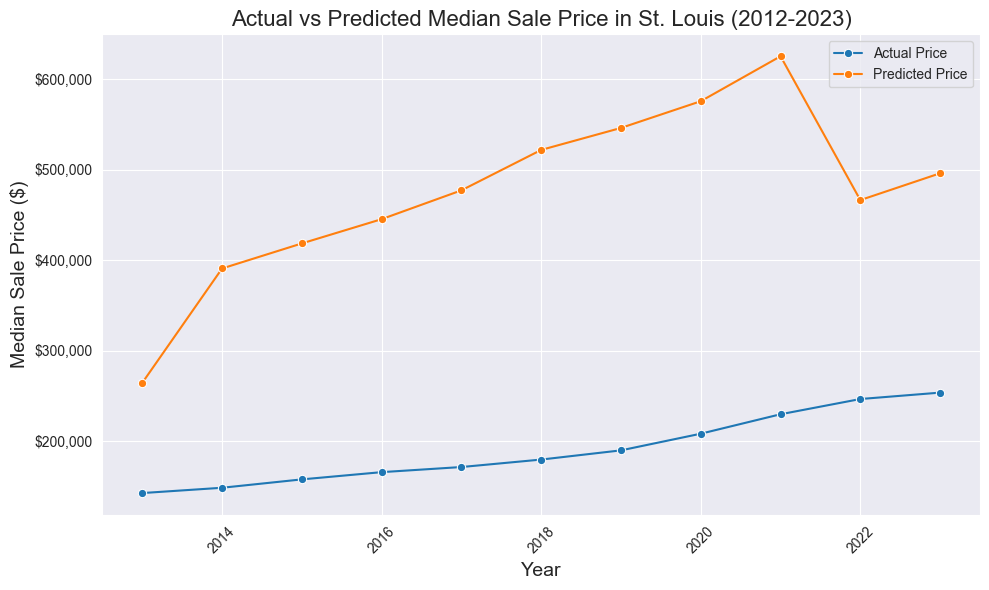

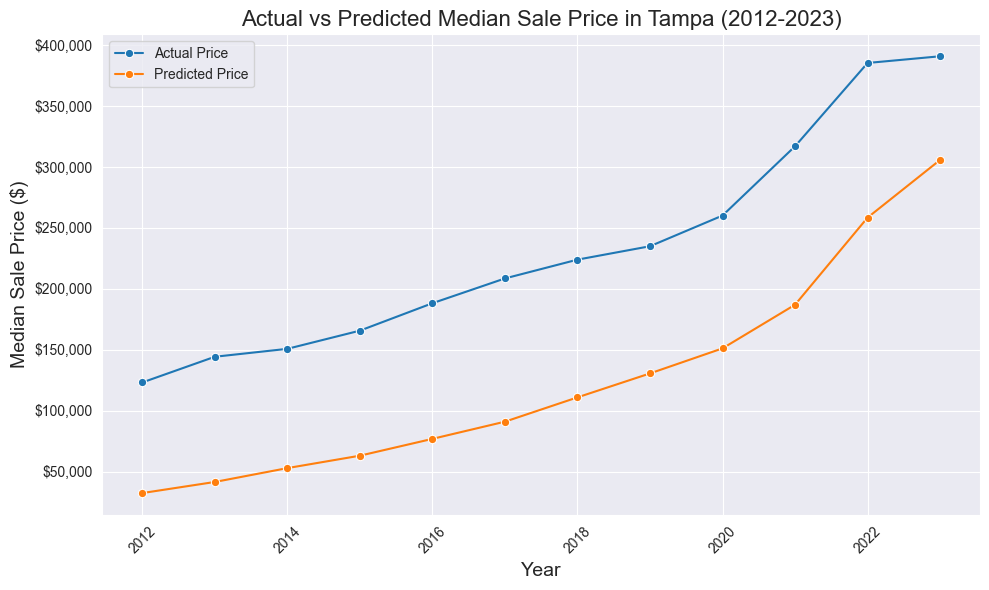

In [35]:
#Create individual line plots for each region plotting actual vs predicted prices
for region in housing_economic_data['Region'].unique():
    region_data = housing_economic_data[housing_economic_data['Region'] == region]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=region_data, x='Year', y='Median_Sale_Price', label='Actual Price', marker='o')
    sns.lineplot(data=region_data, x='Year', y='Predicted_Median_Sale_Price', label='Predicted Price', marker='o')
    plt.title(f'Actual vs Predicted Median Sale Price in {region} (2012-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Median Sale Price ($)', fontsize=14)
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    plt.tight_layout()
    plt.show()


Step 14: Count 'Overvalued' vs 'Undervalued' by Region

In [36]:
#Count the number of 'Overvalued' vs 'Undervalued' by Region
valuation_counts = housing_economic_data.groupby(['Region', 'Price_Classification']).size().unstack(fill_value=0)

#Sort by highest to lowest in the 'Overvalued' column
valuation_counts = valuation_counts.sort_values(by='Overvalued', ascending=False)

print(valuation_counts)

Price_Classification  Overvalued  Undervalued
Region                                       
Riverside                     12            0
Miami                         12            0
Houston                       12            0
San Francisco                 12            0
Seattle                       12            0
Phoenix                       12            0
Tampa                         12            0
San Diego                      8            4
Los Angeles                    4            8
Philadelphia                   3            9
Denver                         1           11
Boston                         0           12
Baltimore                      0           12
Atlanta                        0           12
Detroit                        0           11
New York                       0            9
Minneapolis                    0           12
Chicago                        0           12
St. Louis                      0           11


Step 15: Export valuation counts to excel

In [37]:
#Export the valuation_counts dataframe to a csv file
valuation_counts.to_csv('housing_valuation_counts_by_region.csv')